In [1]:
#import and dependencies
import pandas as pd
import numpy as np
import matplotlib as mpl
from os.path import join as pj
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# getting bigger figures
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
# constants
root = "/Users/sstoma/Projects/21-01-29-malwina/"
ver = "08"
results_path = "21-09-20-malwina,ia,slide,scanner,crops/_out_v_%s/" % (ver)
data_path = "_data/21-09-21/"
nuclei_fn = "MyExpt_obj_nucleus.csv"
actin_fn = "MyExpt_obj_actin.csv"
probes_fn = "MyExpt_obj_probes_masked.csv"
images_fn = "MyExpt_Image.csv"
#annotation1_fn = "Treated Corneas_2.xlsx"
#annotation2_fn = "Spreadsheet_ImageAnalysis_trials_good_quality_EM.xlsx"
annotation3_fn = "22-02-22_overview_dataset_EM_complete.xlsx"
discrete_distance_um = 40
max_y = 800 # closest to normalization - we select only a fraction of the image from the top to account for different image sizes
            # 800 is y of smallest possible image
derivative_thr = -0.025 # used to autodetect the penetration depth based on the signal derivative. If the signal is larger than this value, we assume that the function is still decreesing, and we observe spatial influence
x_lim = 0
y_lim = None

In [4]:

important_field_names = """
FileName_img - in CP output the  name of the processed image
Intensity_MeanIntensity_img_distance - distance to boundary
Intensity_MeanIntensity_img_phallo_bkg_corr - intensity of phaloidine in normalized phallo image
Intensity_MeanIntensity_img_phallo - intensity of phaloidine
"""
lab_distance = "Intensity_MeanIntensity_img_distance"
lab_phallo_int = "Intensity_MeanIntensity_img_phallo"
lab_phallo_no_bkg_int = "Intensity_MeanIntensity_img_phallo_bkg_corr"
lab_dapi_int = "Intensity_MeanIntensity_img_dapi"
lab_experiment_group = "GroupNew"
lab_image_number = "ImageNumber"
lab_discrete_distance = "Discrete_Distance " + " x " + str(discrete_distance_um) + " um"
lab_area = "AreaShape_Area"
lab_y_coord = "AreaShape_Center_Y"
lab_filename = "FileName_img"

normalized = True
labs_to_normalize = [
    lab_phallo_int,
    lab_phallo_no_bkg_int,
    lab_dapi_int,
    lab_area
]

group_order = ["Epion", "epioff", "En1", "En10.4", "En1PM", "En3", "En3nR" ]

In [5]:
# data loading
nuclei = pd.read_csv( pj(root, results_path, nuclei_fn ))
actin = pd.read_csv( pj(root, results_path, actin_fn ))
probes = pd.read_csv( pj(root, results_path, probes_fn ))
all_obj = [nuclei, actin, probes]
images = pd.read_csv( pj(root, results_path, images_fn ))
#annotation1 = pd.read_excel( pj(root, data_path, annotation1_fn ))
#annotation2 = pd.read_excel( pj(root, data_path, annotation2_fn ))
#annotation1_2 = pd.merge(annotation1, annotation2, on=["ID"])
annotation3 = pd.read_excel( pj(root, data_path, annotation3_fn ))
annotation = annotation3
annotation.head()

,Cut outs,Date of death,Slide,ID,Tx,GroupNew,Quality
0,41.1,201214,slide-2021-05-11T20-49-27-R1-S14,41,En1,En1,ok
1,41.2,201214,slide-2021-05-11T20-49-27-R1-S14,41,En1,En1,ok
2,41.3,201214,slide-2021-05-11T20-49-27-R1-S14,41,En1,En1,ok
3,41.0,201214,slide-2021-05-11T20-49-27-R1-S14,41,Epion,Epion,ok
4,42.1,201214,slide-2021-05-11T21-01-56-R1-S15,42,En1,En1,ok


In [6]:
annotation.groupby("GroupNew").count()

,Cut outs,Date of death,Slide,ID,Tx,Quality
GroupNew,,,,,,
En1,111,111,108,111,111,108
En10.4,45,45,45,45,45,45
En1PM,54,54,54,54,54,54
En3,57,57,57,57,57,57
En3nR,45,45,45,45,45,45
Epion,99,99,99,99,99,99
epioff,129,129,129,129,129,129


In [7]:
# changing distance from px to um
probes[ lab_distance ] = probes[ lab_distance ] * 0.389 # this number is from matadata
probes.head()
nuclei[ lab_distance ] = nuclei[ lab_distance ] * 0.389 # this number is from matadata
nuclei.head()
actin[ lab_distance ] = actin[ lab_distance ] * 0.389 # this number is from matadata
actin.head()

,ImageNumber,ObjectNumber,AreaShape_Area,AreaShape_BoundingBoxArea,AreaShape_BoundingBoxMaximum_X,AreaShape_BoundingBoxMaximum_Y,AreaShape_BoundingBoxMinimum_X,AreaShape_BoundingBoxMinimum_Y,AreaShape_Center_X,AreaShape_Center_Y,...,Location_MaxIntensity_Y_img_dapi,Location_MaxIntensity_Y_img_distance,Location_MaxIntensity_Y_img_phallo,Location_MaxIntensity_Y_img_phallo_bkg_corr,Location_MaxIntensity_Z_img_background,Location_MaxIntensity_Z_img_dapi,Location_MaxIntensity_Z_img_distance,Location_MaxIntensity_Z_img_phallo,Location_MaxIntensity_Z_img_phallo_bkg_corr,Number_Object_Number
0,1,1,1,1,657,3,656,2,656.000000,2.000000,...,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1
1,1,2,13,20,2543,5,2538,1,2539.846154,2.615385,...,3.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2
2,1,3,5,9,901,5,898,2,899.000000,3.000000,...,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,3
3,1,4,24,35,2083,6,2076,1,2078.875000,2.708333,...,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,4
4,1,5,35,40,837,9,832,1,834.057143,4.600000,...,8.0,8.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,5


In [8]:
annotation.head()

,Cut outs,Date of death,Slide,ID,Tx,GroupNew,Quality
0,41.1,201214,slide-2021-05-11T20-49-27-R1-S14,41,En1,En1,ok
1,41.2,201214,slide-2021-05-11T20-49-27-R1-S14,41,En1,En1,ok
2,41.3,201214,slide-2021-05-11T20-49-27-R1-S14,41,En1,En1,ok
3,41.0,201214,slide-2021-05-11T20-49-27-R1-S14,41,Epion,Epion,ok
4,42.1,201214,slide-2021-05-11T21-01-56-R1-S15,42,En1,En1,ok


In [9]:
def change_name( x ):
    if x[-2:] == ".0":
        x = x[:-2]
    return x+".tif"

# adapting "images" to merge
annotation["Cut outs"] = annotation["Cut outs"].astype(str)
#annotation["Cut outs"] = annotation["Cut outs"].apply(lambda x: x + ".tif")
#dealing with names without .N
annotation["Cut outs"] = annotation["Cut outs"].apply( change_name )
images = pd.merge(images, annotation, how="left", left_on=["FileName_img"], right_on=["Cut outs"])
images["ImageNumber"] = range(1, len(images) + 1) #TODO 1. it can be messing up. 2. I need it to do pd.merge
images.head()

,AreaOccupied_AreaOccupied_obj_actin,AreaOccupied_AreaOccupied_obj_mask,AreaOccupied_AreaOccupied_obj_nucleus,AreaOccupied_AreaOccupied_obj_probes_masked,AreaOccupied_Perimeter_obj_actin,AreaOccupied_Perimeter_obj_mask,AreaOccupied_Perimeter_obj_nucleus,AreaOccupied_Perimeter_obj_probes_masked,AreaOccupied_TotalArea_obj_actin,AreaOccupied_TotalArea_obj_mask,...,Width_img_background,Width_img_boundary,Width_img_mask,Cut outs,Date of death,Slide,ID,Tx,GroupNew,Quality
0,459103.0,4617710.0,147252.0,971831.0,228354.0,8983.0,30525.0,80695.0,4617710.0,5066478.0,...,3114,3114,3114,102.1.tif,210419,slide-2021-06-01T18-40-51-R1-S3,102,epioff,epioff,ok
1,553337.0,5465349.0,217967.0,1133393.0,278268.0,9603.0,40570.0,94886.0,5465349.0,6325853.0,...,3293,3293,3293,102.2.tif,210419,slide-2021-06-01T18-40-51-R1-S3,102,epioff,epioff,ok
2,363377.0,4063344.0,124891.0,838125.0,188709.0,8642.0,28594.0,69831.0,4063344.0,4400440.0,...,3014,3014,3014,102.3.tif,210419,slide-2021-06-01T18-40-51-R1-S3,102,epioff,epioff,ok
3,680039.0,8698935.0,232526.0,1587887.0,350212.0,13146.0,44120.0,130909.0,8698935.0,10687176.0,...,5436,5436,5436,102.tif,210419,slide-2021-06-01T18-40-51-R1-S3,102,Epion,Epion,ok
4,276580.0,2878244.0,108373.0,614461.0,138281.0,7752.0,22986.0,51901.0,2878244.0,3173376.0,...,3099,3099,3099,103.1.tif,210419,slide-2021-06-01T18-54-57-R1-S4,103,epioff,epioff,ok


In [10]:
annotation.head()

,Cut outs,Date of death,Slide,ID,Tx,GroupNew,Quality
0,41.1.tif,201214,slide-2021-05-11T20-49-27-R1-S14,41,En1,En1,ok
1,41.2.tif,201214,slide-2021-05-11T20-49-27-R1-S14,41,En1,En1,ok
2,41.3.tif,201214,slide-2021-05-11T20-49-27-R1-S14,41,En1,En1,ok
3,41.tif,201214,slide-2021-05-11T20-49-27-R1-S14,41,Epion,Epion,ok
4,42.1.tif,201214,slide-2021-05-11T21-01-56-R1-S15,42,En1,En1,ok


In [11]:
# adding experiment labels
probes = pd.merge(probes, images[[lab_image_number, lab_experiment_group]], how="left", on=[lab_image_number])
probes.head()
nuclei = pd.merge(nuclei, images[[lab_image_number, lab_experiment_group]], how="left", on=[lab_image_number])
nuclei.head()
actin = pd.merge(actin, images[[lab_image_number, lab_experiment_group]], how="left", on=[lab_image_number])
actin.head()

,ImageNumber,ObjectNumber,AreaShape_Area,AreaShape_BoundingBoxArea,AreaShape_BoundingBoxMaximum_X,AreaShape_BoundingBoxMaximum_Y,AreaShape_BoundingBoxMinimum_X,AreaShape_BoundingBoxMinimum_Y,AreaShape_Center_X,AreaShape_Center_Y,...,Location_MaxIntensity_Y_img_distance,Location_MaxIntensity_Y_img_phallo,Location_MaxIntensity_Y_img_phallo_bkg_corr,Location_MaxIntensity_Z_img_background,Location_MaxIntensity_Z_img_dapi,Location_MaxIntensity_Z_img_distance,Location_MaxIntensity_Z_img_phallo,Location_MaxIntensity_Z_img_phallo_bkg_corr,Number_Object_Number,GroupNew
0,1,1,1,1,657,3,656,2,656.000000,2.000000,...,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1,epioff
1,1,2,13,20,2543,5,2538,1,2539.846154,2.615385,...,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2,epioff
2,1,3,5,9,901,5,898,2,899.000000,3.000000,...,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,3,epioff
3,1,4,24,35,2083,6,2076,1,2078.875000,2.708333,...,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,4,epioff
4,1,5,35,40,837,9,832,1,834.057143,4.600000,...,8.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,5,epioff


In [12]:
# what kind of experiments data we have?
list(probes)
#probes[ lab_experiment_group ].unique()

['ImageNumber',
 'ObjectNumber',
 'AreaShape_Area',
 'AreaShape_BoundingBoxArea',
 'AreaShape_BoundingBoxMaximum_X',
 'AreaShape_BoundingBoxMaximum_Y',
 'AreaShape_BoundingBoxMinimum_X',
 'AreaShape_BoundingBoxMinimum_Y',
 'AreaShape_Center_X',
 'AreaShape_Center_Y',
 'AreaShape_Compactness',
 'AreaShape_ConvexArea',
 'AreaShape_Eccentricity',
 'AreaShape_EquivalentDiameter',
 'AreaShape_EulerNumber',
 'AreaShape_Extent',
 'AreaShape_FormFactor',
 'AreaShape_MajorAxisLength',
 'AreaShape_MaxFeretDiameter',
 'AreaShape_MaximumRadius',
 'AreaShape_MeanRadius',
 'AreaShape_MedianRadius',
 'AreaShape_MinFeretDiameter',
 'AreaShape_MinorAxisLength',
 'AreaShape_Orientation',
 'AreaShape_Perimeter',
 'AreaShape_Solidity',
 'Intensity_IntegratedIntensityEdge_img_background',
 'Intensity_IntegratedIntensityEdge_img_dapi',
 'Intensity_IntegratedIntensityEdge_img_distance',
 'Intensity_IntegratedIntensityEdge_img_phallo',
 'Intensity_IntegratedIntensityEdge_img_phallo_bkg_corr',
 'Intensity_Inte

In [13]:
def add_distance_segments(df, distance_name, step):
    df[ lab_discrete_distance ]  = (df[ distance_name ] / step).round()

add_distance_segments( probes, lab_distance, discrete_distance_um)
add_distance_segments( nuclei, lab_distance, discrete_distance_um)
add_distance_segments( actin, lab_distance, discrete_distance_um)

# cleaning the images based on visual inspection

In [14]:
images2exclude = [
    '148.tif', 
    '133.1.tif',
    '125.3.tif',
    '138.2.tif',
    '138.3.tif',
    '59.1.tif',
]
images2exclude_fibers = [
    '104.1.tif',
    '136.1.tif',
    '136.2.tif',
    '136.3.tif',
    '83.1.tif',
    '93.1.tif',
    
    '132.2.tif', 
    '143.2.tif', 
    '146.1.tif', 
    '148.1.tif', 
    '148.2.tif', 
    '148.3.tif', 
    '150.1.tif', 
    '150.2.tif', 
    '150.3.tif', 
    '169.2.tif', 
    '169.3.tif', 
    '187.1.tif',
    
    '108.1.tif',
    '108.2.tif', 
    '109.2.tif', 
    '110.2.tif', 
    '110.3.tif', 
    '181.1.tif', 
    '181.2.tif', 
    '182.3.tif', 
    '183.2.tif', 
    '95.1.tif', 
    '95.2.tif', 
    '96.2.tif', 
    '96.3.tif', 
    '99.1.tif', 
    '99.2.tif',
    
    '116.1.tif', 
    '44.1.tif', 
    '44.3.tif', 
    '59.2.tif', 
    '66.1.tif', 
    '66.2.tif', 
    '66.3.tif', 
    '67.3.tif', 
    '75.1.tif', 
    '75.2.tif', 
    '75.3.tif', 
    '77.1.tif', 
    '77.2.tif', 
    '77.3.tif', 
    '87.1.tif', 
    '87.3.tif', 
    '88.1.tif', 
    '88.2.tif', 
    '88.3.tif', 
]
images_nbr2exclude = [images[ images[lab_filename] == i ][ lab_image_number ].squeeze() for i in images2exclude]
images_nbr2exclude_fibers = [images[ images[lab_filename] == i ][ lab_image_number ].squeeze() for i in images2exclude_fibers]
actin = actin[~actin[ lab_image_number ].isin(images_nbr2exclude+images_nbr2exclude_fibers)]
probes = probes[~probes[ lab_image_number ].isin(images_nbr2exclude)]
nuclei = nuclei[~nuclei[ lab_image_number ].isin(images_nbr2exclude)]

In [15]:
# we need a reference baseline value to normalize some quantities. We assume that after 800um there is no difference so we use these objects to compute baseline object that is used for the normalization
min_baseline_distance = 900
max_baseline_distance = 1000
probes_base = probes[ (probes[ lab_distance ] > min_baseline_distance) & (probes[ lab_distance ] < max_baseline_distance) & (probes[ lab_y_coord ] < max_y)]
nuclei_base = nuclei[ (nuclei[ lab_distance ] > min_baseline_distance) & (nuclei[ lab_distance ] < max_baseline_distance) & (nuclei[ lab_y_coord ] < max_y)]
actin_base  =  actin[ (actin [ lab_distance ] > min_baseline_distance) & (actin [ lab_distance ] < max_baseline_distance) & (actin [ lab_y_coord ] < max_y)]

#  trim data to only 800 um from boundary
um_range = 800
min_um_range = 50
probes = probes[ (probes[ lab_distance ] > min_um_range) & (probes[ lab_distance ] < um_range) & (probes[ lab_y_coord ] < max_y)]
nuclei = nuclei[ (nuclei[ lab_distance ] > min_um_range) & (nuclei[ lab_distance ] < um_range) & (nuclei[ lab_y_coord ] < max_y)]
actin = actin[ (actin[ lab_distance ] > min_um_range) & (actin[ lab_distance ] < um_range) & (actin[ lab_y_coord ] < max_y)]


In [16]:
glob_num = 0
def num():
    global glob_num    # Needed to modify global copy of globvar
    glob_num += 1
    return glob_num

# Normalization

In [17]:
if normalized:
    img_ids = probes["ImageNumber"].unique()
    for i in img_ids:
        for j in labs_to_normalize:
            av = probes_base[ probes_base[ "ImageNumber" ] == i ][ j ].mean()
            probes.loc[ probes[ "ImageNumber" ] == i, j ] = probes.loc[ probes[ "ImageNumber" ] == i, j ] / av
            av = actin_base[ actin_base[ "ImageNumber" ] == i ][ j ].mean()
            actin.loc[ actin[ "ImageNumber" ] == i, j ] = actin.loc[ actin[ "ImageNumber" ] == i, j ] / av 
            av = nuclei_base[ nuclei_base[ "ImageNumber" ] == i ][ j ].mean()
            nuclei.loc[ nuclei[ "ImageNumber" ] == i, j ] = nuclei.loc[ nuclei[ "ImageNumber" ] == i, j ] / av 

In [18]:
def l_normalized():
    if normalized: return "Normalized "
    else: return ""

## Checking intensities for medium in Phaloidin channel

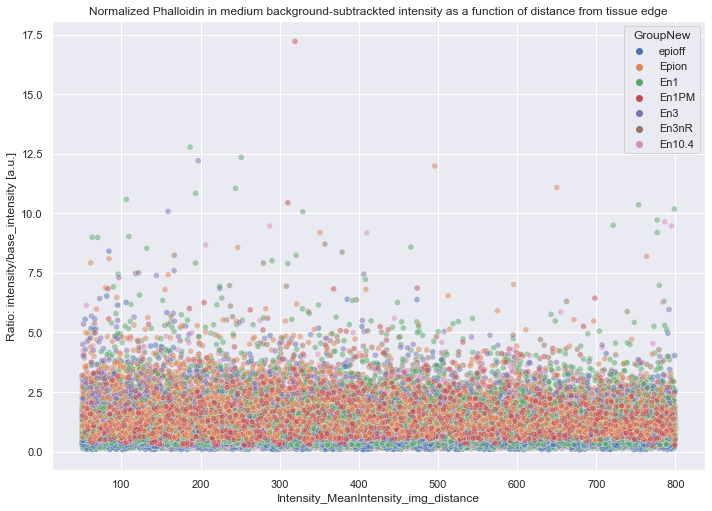

In [19]:
f = sns.scatterplot(
    x=lab_distance, 
    y=lab_phallo_no_bkg_int, 
    data=probes, 
    hue=lab_experiment_group, 
    marker='o', 
    sizes=0.1, 
    alpha=0.5)
f.set(
    title=l_normalized()+"Phalloidin in medium background-subtrackted intensity as a function of distance from tissue edge",
    ylabel=(lambda x: "Ratio: intensity/base_intensity [a.u.]" if x else "Intensity [a.u.]")(normalized)
)
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)
                 

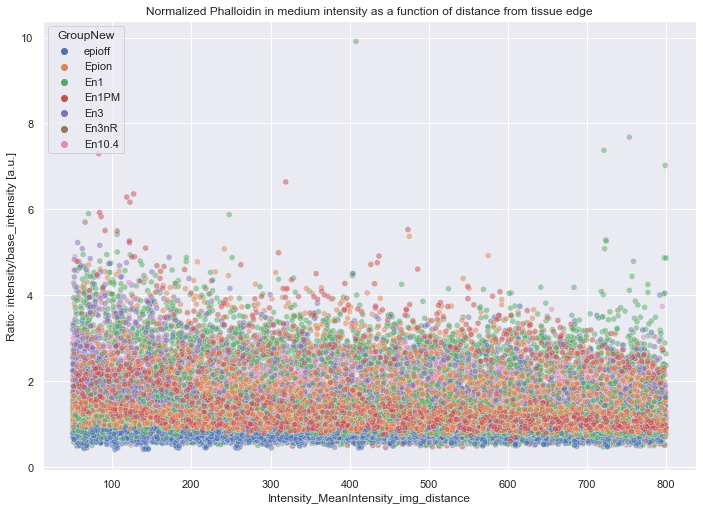

In [20]:
f = sns.scatterplot(
    x=lab_distance, 
    y=lab_phallo_int, 
    data=probes, 
    hue=lab_experiment_group, 
    marker='o', 
    sizes=0.1, 
    alpha=0.5)
f.set(
    title=l_normalized()+"Phalloidin in medium intensity as a function of distance from tissue edge",
    ylabel=(lambda x: "Ratio: intensity/base_intensity [a.u.]" if x else "Intensity [a.u.]")(normalized)
)
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

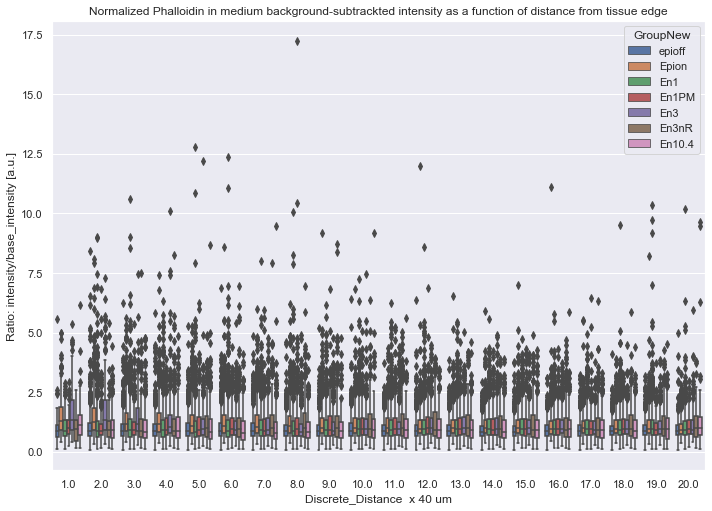

In [21]:
f = sns.boxplot(
    x=lab_discrete_distance, 
    y=lab_phallo_no_bkg_int, 
    data=probes, 
    hue=lab_experiment_group)
f.set(
    title=l_normalized()+"Phalloidin in medium background-subtrackted intensity as a function of distance from tissue edge",
    ylabel=(lambda x: "Ratio: intensity/base_intensity [a.u.]" if x else "Intensity [a.u.]")(normalized)
)
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

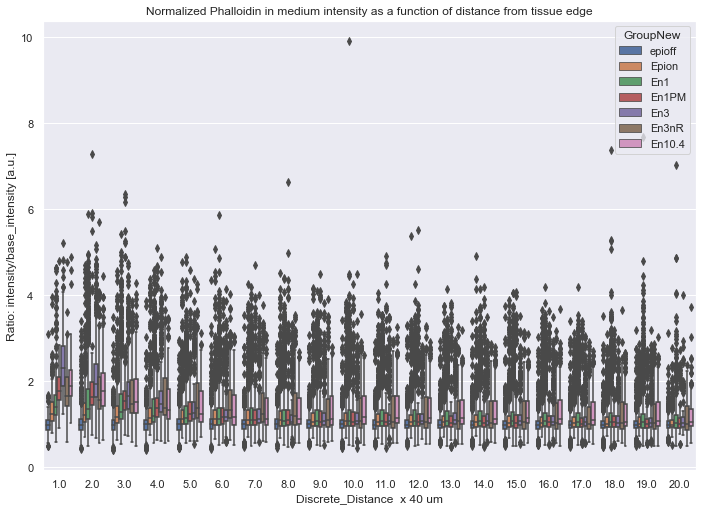

In [22]:
f = sns.boxplot(
    x=lab_discrete_distance, 
    y=lab_phallo_int, 
    data=probes, 
    hue=lab_experiment_group)
f.set(
    title=l_normalized()+"Phalloidin in medium intensity as a function of distance from tissue edge",
    ylabel=(lambda x: "Ratio: intensity/base_intensity [a.u.]" if x else "Intensity [a.u.]")(normalized)
)
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

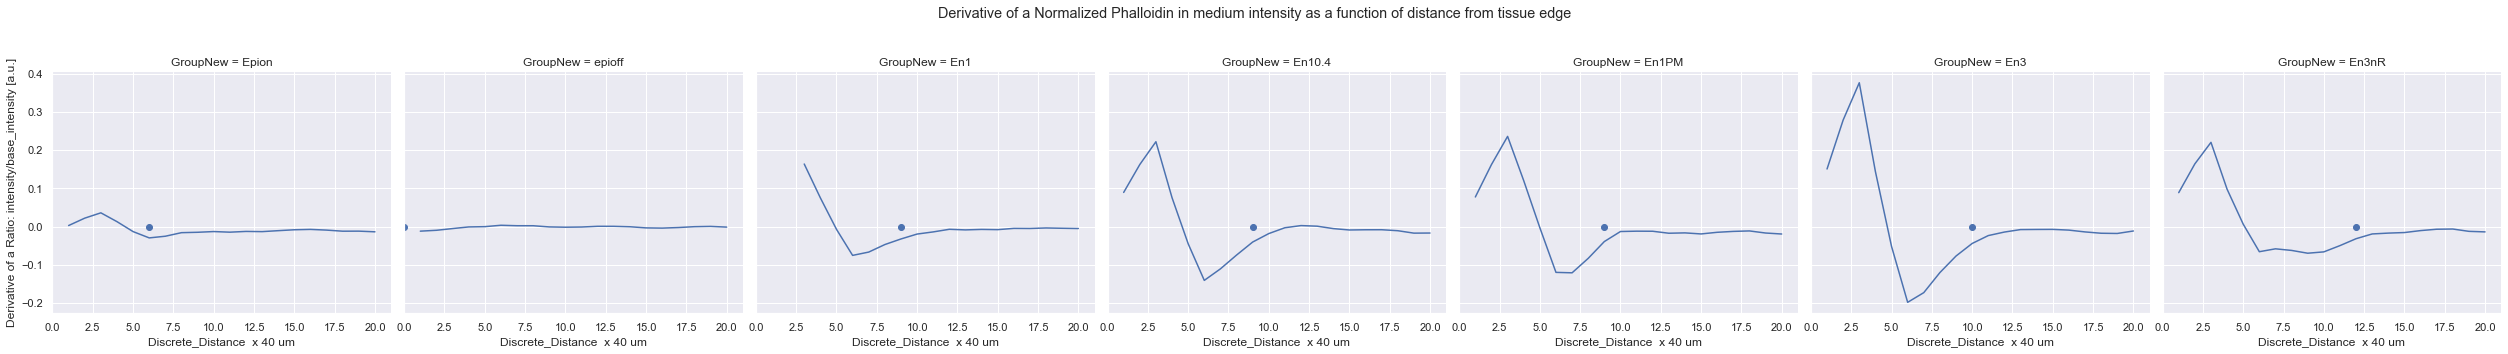

In [23]:
# compute derivate
x =  probes.groupby([lab_image_number, lab_experiment_group, lab_discrete_distance]).agg('mean').rolling(3).mean().diff().groupby([lab_experiment_group, lab_discrete_distance]).agg('mean').rolling(3).mean()
x.reset_index(inplace=True)

# function to find x where the derivative is smaller than thr
# we go from the right, we assume that the function is decreasing
# we want to find an x where the function switches from flat to slowly decreasing
# thr. defines the meaning what is "slowly"
skip_last_n_points = 3
def f( data, group, feature ):
    trimmed = data[ data[lab_experiment_group] == group][[lab_discrete_distance, lab_phallo_int]]
    trimmed2 = trimmed.reset_index()
    #print(trimmed2)
    for i in reversed( range(len( trimmed2) - skip_last_n_points )):
        if trimmed2[feature][ i ] < derivative_thr:
            return trimmed2[lab_discrete_distance][i]
    return 0

pos_x = []
for i in group_order:
    pos_x.append( f(x, i, lab_phallo_int) )
#print( pos_x )

f = sns.relplot(
    y=lab_phallo_int, 
    x=lab_discrete_distance,
    data=x, 
    col=lab_experiment_group, 
    kind="line",
    col_order=group_order
)
for i in range(len(f.axes[0])):
    f.axes[0][i].scatter(pos_x[i],0.,)
f.set(
    #title="Phaloidin in medium normalized intensity as a function of distance from tissue edge",
    ylabel=(lambda x: "Derivative of a Ratio: intensity/base_intensity [a.u.]" if x else "Intensity [a.u.]")(normalized),
    xlim=(x_lim, y_lim),
)
f.fig.suptitle( "Derivative of a "+l_normalized()+"Phalloidin in medium intensity as a function of distance from tissue edge" )
f.fig.subplots_adjust( top=.8 )
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

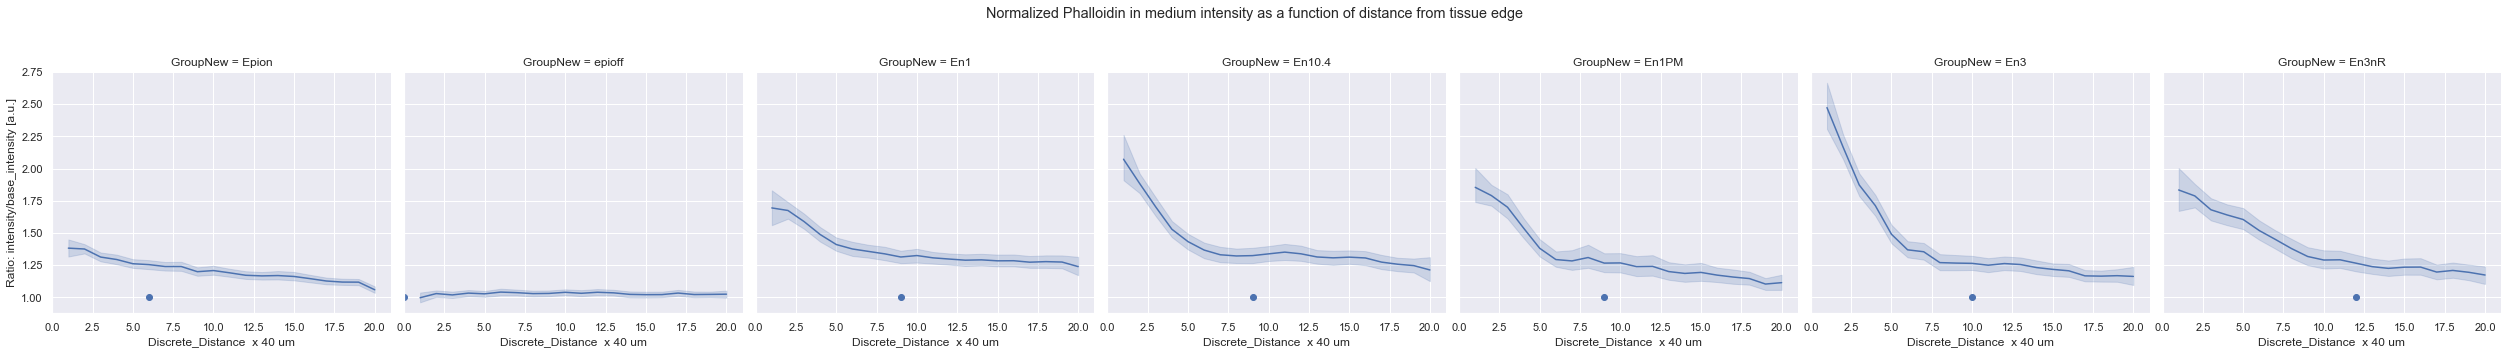

In [24]:
f = sns.relplot(
    y=lab_phallo_int, 
    x=lab_discrete_distance,
    data=probes, 
    col=lab_experiment_group, 
    kind="line",
    col_order=group_order
)
for i in range(len(f.axes[0])):
    f.axes[0][i].scatter(pos_x[i],1.,)
f.set(
    #title="Phaloidin in medium normalized intensity as a function of distance from tissue edge",
    ylabel=(lambda x: "Ratio: intensity/base_intensity [a.u.]" if x else "Intensity [a.u.]")(normalized),
    xlim=(x_lim, y_lim),
)
f.fig.suptitle( l_normalized()+"Phalloidin in medium intensity as a function of distance from tissue edge" )
f.fig.subplots_adjust( top=.8 )
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

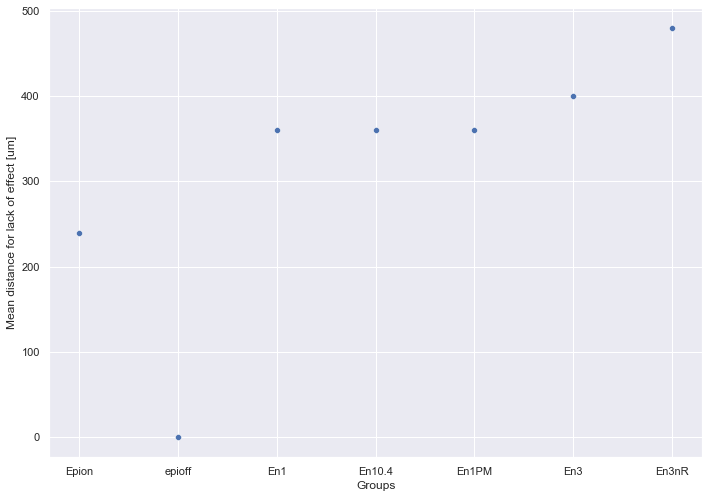

In [25]:
df = pd.DataFrame(data={"Groups":group_order, "Distance [um]": np.array( pos_x ) * discrete_distance_um})
f = sns.scatterplot(
    y="Distance [um]", 
    x="Groups",
    data=df, 
    #col_order=group_order
)
f.set(
    #title="Phaloidin in medium normalized intensity as a function of distance from tissue edge",
    ylabel="Mean distance for lack of effect [um]"#lab_discrete_distance#(lambda x: "Groups" if x else "Intensity [a.u.]")(normalized)
)
#f.fig.suptitle( l_normalized()+"Distance from tissue edge where we observe no difference" )
#f.fig.subplots_adjust( top=.8 )
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

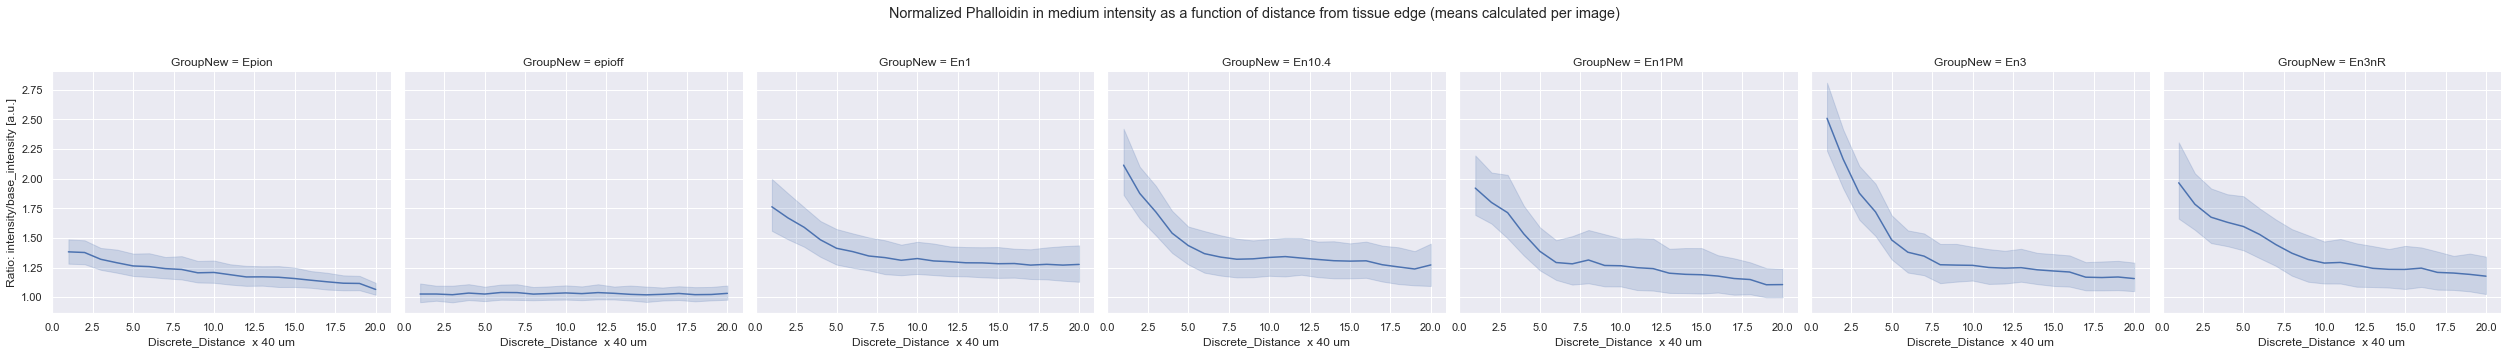

In [26]:
f = sns.relplot(
    y=lab_phallo_int, 
    x=lab_discrete_distance,
    data=probes.groupby( [ lab_experiment_group, lab_image_number, lab_discrete_distance] ).mean(), 
    col=lab_experiment_group, 
    kind="line",
    col_order=group_order
)
f.set(
    #title="Phaloidin in medium normalized intensity as a function of distance from tissue edge",
    ylabel=(lambda x: "Ratio: intensity/base_intensity [a.u.]" if x else "Intensity [a.u.]")(normalized),
    xlim=(x_lim, y_lim),
)
f.fig.suptitle( l_normalized()+"Phalloidin in medium intensity as a function of distance from tissue edge (means calculated per image)" )
f.fig.subplots_adjust( top=.8 )
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

## Studying variability between images  

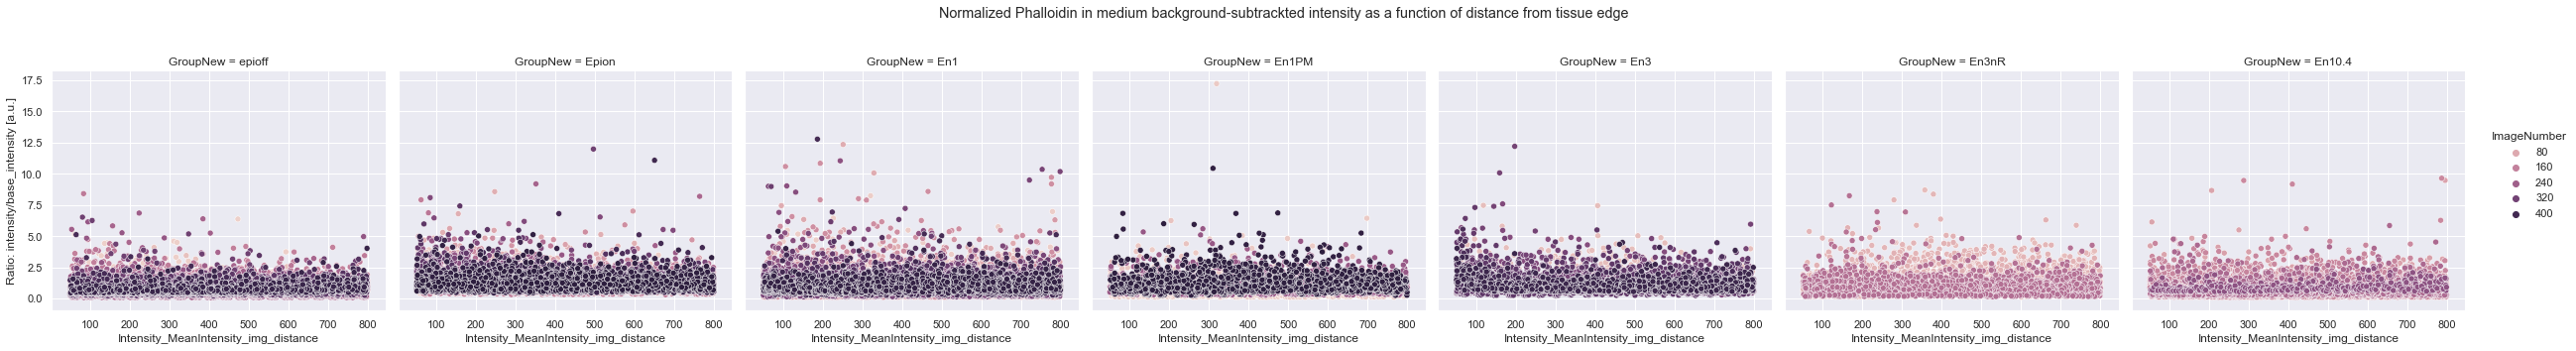

In [27]:
f= sns.relplot(
    x=lab_distance, 
    y=lab_phallo_no_bkg_int, 
    data=probes, 
    col=lab_experiment_group, 
    hue=lab_image_number, 
    kind="scatter")
f.set(
    ylabel=(lambda x: "Ratio: intensity/base_intensity [a.u.]" if x else "Intensity [a.u.]")(normalized)
)
f.fig.suptitle( l_normalized()+"Phalloidin in medium background-subtrackted intensity as a function of distance from tissue edge" )
f.fig.subplots_adjust( top=.8 )
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

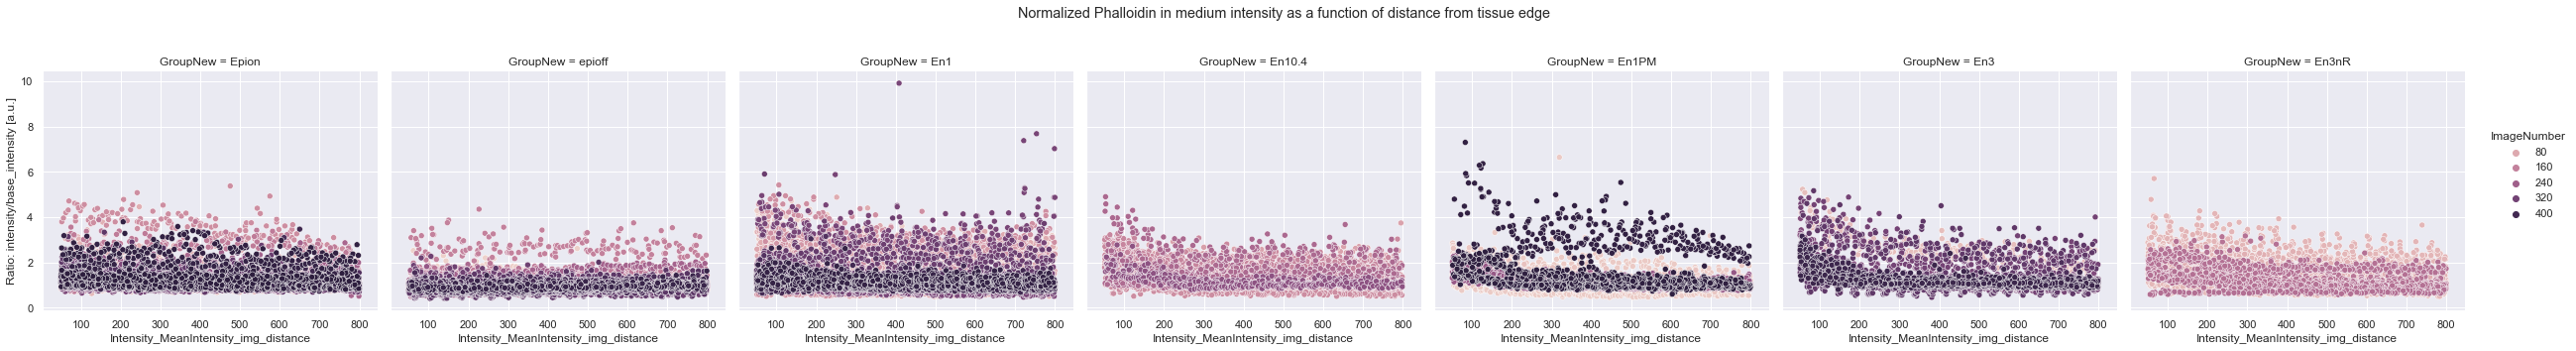

In [28]:
f = sns.relplot(
    x=lab_distance, 
    y=lab_phallo_int, 
    data=probes, 
    col=lab_experiment_group, 
    hue=lab_image_number, 
    kind="scatter",
    col_order=group_order)
f.set(
    ylabel=(lambda x: "Ratio: intensity/base_intensity [a.u.]" if x else "Intensity [a.u.]")(normalized)
)
f.fig.suptitle( l_normalized()+"Phalloidin in medium intensity as a function of distance from tissue edge" )
f.fig.subplots_adjust( top=.8 )
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

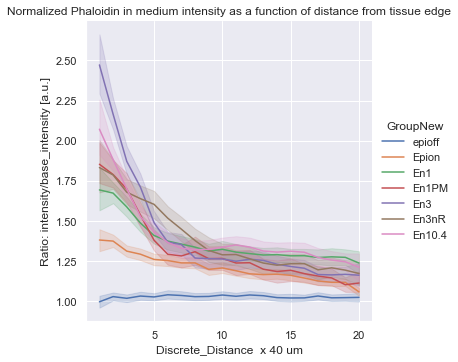

In [29]:
f = sns.relplot(
    x=lab_discrete_distance, 
    y=lab_phallo_int, 
    data=probes, 
    hue=lab_experiment_group,
    kind="line").set(
    title=l_normalized()+"Phaloidin in medium intensity as a function of distance from tissue edge",
    ylabel=(lambda x: "Ratio: intensity/base_intensity [a.u.]" if x else "Intensity [a.u.]")(normalized))
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

## Studying fibers

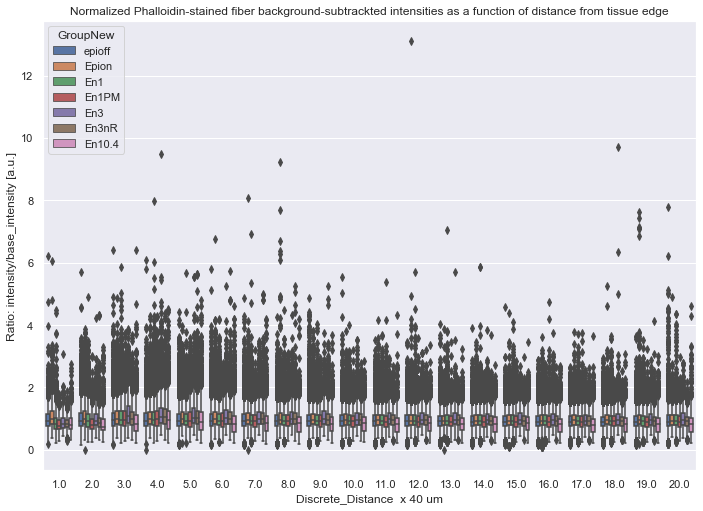

In [30]:
f = sns.boxplot(
    x=lab_discrete_distance, 
    y=lab_phallo_no_bkg_int, 
    data=actin, 
    hue=lab_experiment_group)
f.set(
    title=l_normalized()+"Phalloidin-stained fiber background-subtrackted intensities as a function of distance from tissue edge",
    ylabel=(lambda x: "Ratio: intensity/base_intensity [a.u.]" if x else "Intensity [a.u.]")(normalized)
)
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

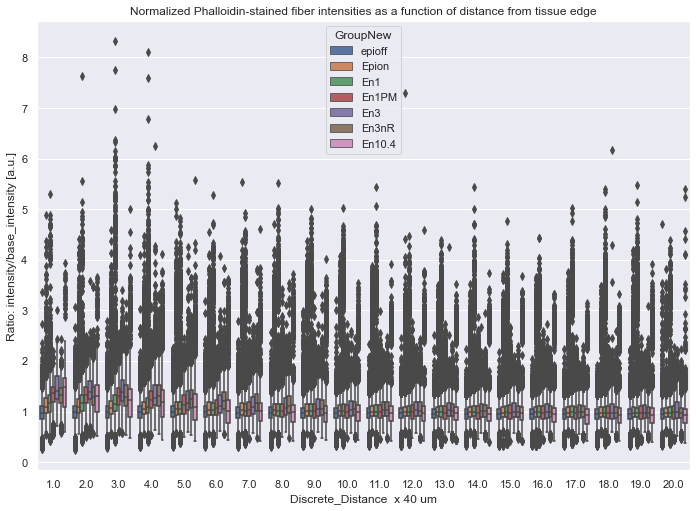

In [31]:
f = sns.boxplot(
    x=lab_discrete_distance, 
    y=lab_phallo_int, 
    data=actin, 
    hue=lab_experiment_group)
f.set(
    title=l_normalized()+"Phalloidin-stained fiber intensities as a function of distance from tissue edge",
    ylabel=(lambda x: "Ratio: intensity/base_intensity [a.u.]" if x else "Intensity [a.u.]")(normalized)
)
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

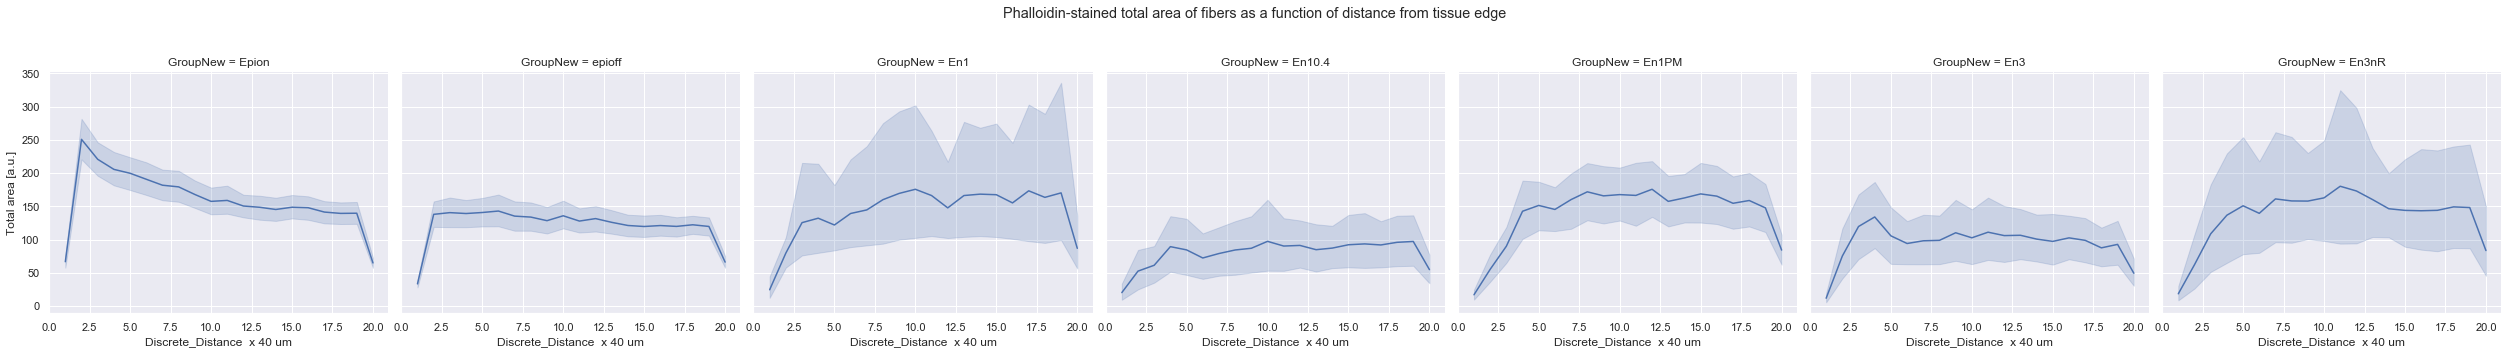

In [32]:
f = sns.relplot(
    y=lab_area, 
    x=lab_discrete_distance, 
    data=actin.groupby( [ lab_experiment_group, lab_discrete_distance, lab_image_number] ).sum(), 
    col=lab_experiment_group, 
    kind="line",
    col_order=group_order
)
f.set(
    ylabel=("Total area [a.u.]"),
    xlim=(x_lim, y_lim),
)
f.fig.suptitle( "Phalloidin-stained total area of fibers as a function of distance from tissue edge" )
f.fig.subplots_adjust( top=.8 )
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

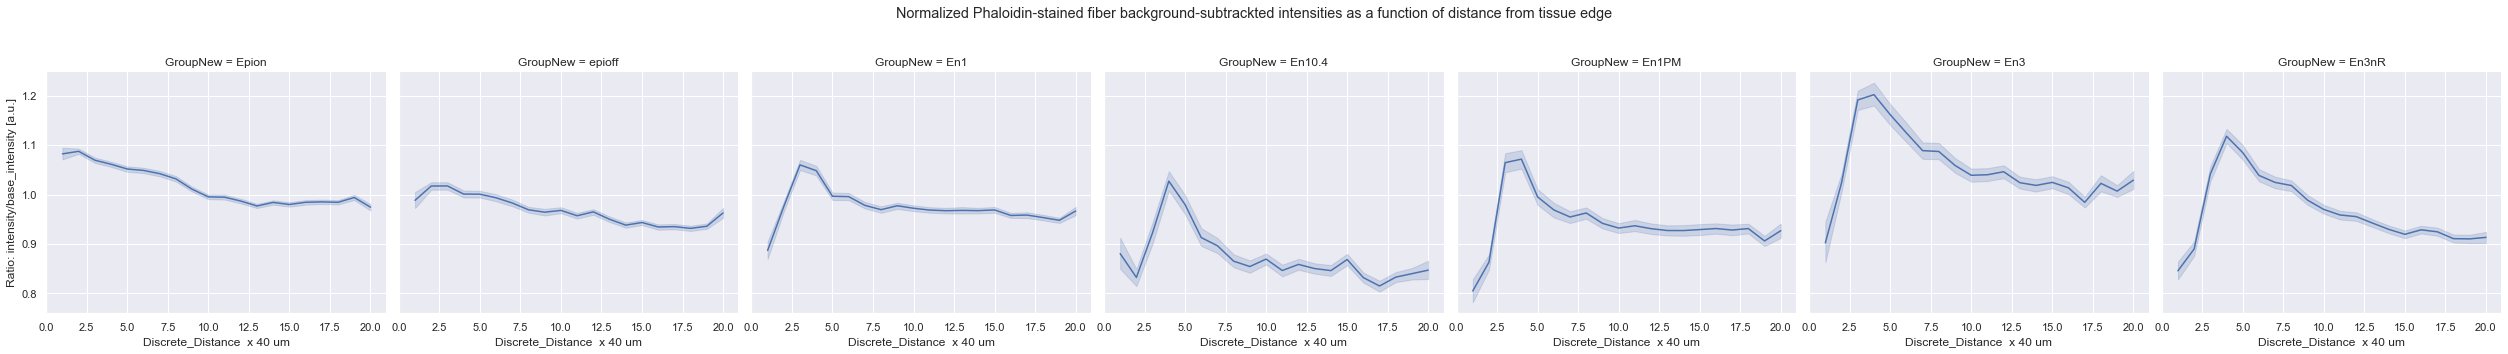

In [33]:
f = sns.relplot(
    y=lab_phallo_no_bkg_int, 
    x=lab_discrete_distance,
    #x=lab_discrete_distance, 
    data=actin,#.groupby( [ lab_experiment_group, lab_image_number] ), 
    col=lab_experiment_group, 
    kind="line",
    col_order=group_order
)
f.set(
    #title="Phaloidin in medium normalized intensity as a function of distance from tissue edge",
    ylabel=(lambda x: "Ratio: intensity/base_intensity [a.u.]" if x else "Intensity [a.u.]")(normalized),
    xlim=(x_lim, y_lim),
)
f.fig.suptitle( l_normalized()+"Phaloidin-stained fiber background-subtrackted intensities as a function of distance from tissue edge" )
f.fig.subplots_adjust( top=.8 )
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

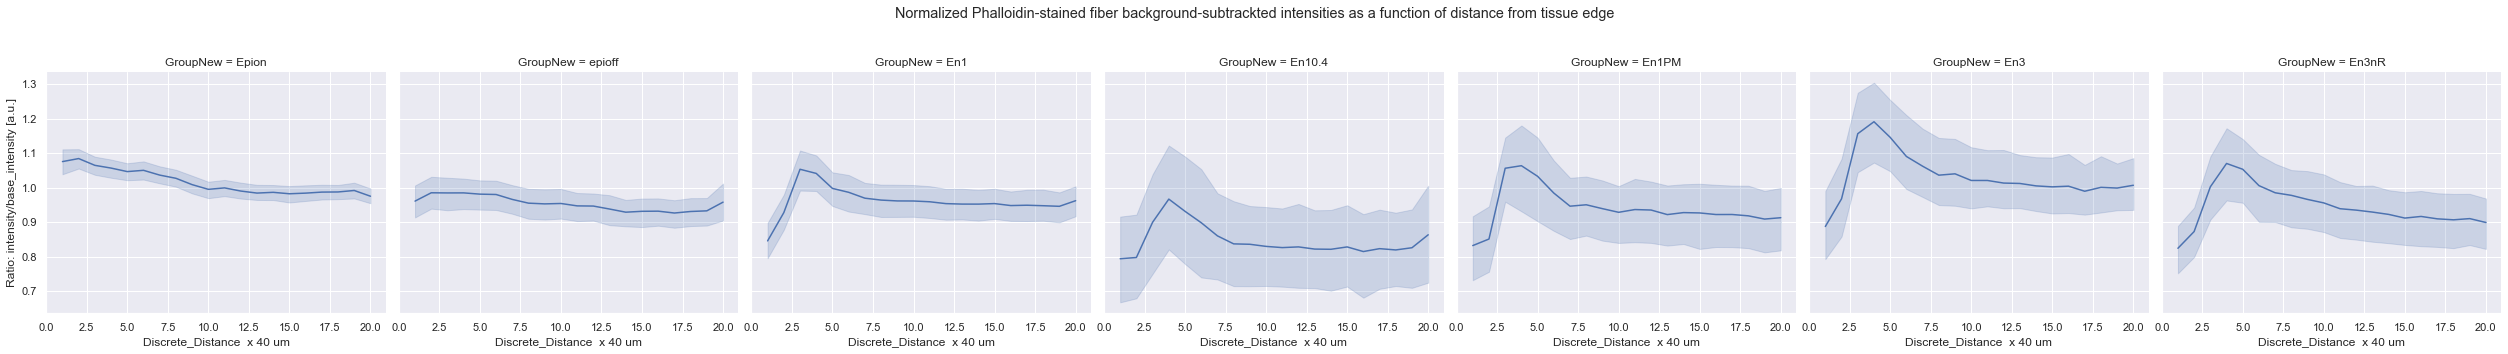

In [34]:
f = sns.relplot(
    y=lab_phallo_no_bkg_int, 
    x=lab_discrete_distance,
    #x=lab_discrete_distance, 
    data=actin.groupby( [ lab_experiment_group, lab_discrete_distance, lab_image_number] ).mean(), 
    col=lab_experiment_group, 
    kind="line",
    col_order=group_order
)
f.set(
    #title="Phaloidin in medium normalized intensity as a function of distance from tissue edge",
    ylabel=(lambda x: "Ratio: intensity/base_intensity [a.u.]" if x else "Intensity [a.u.]")(normalized),
    xlim=(x_lim, y_lim),
)
f.fig.suptitle( l_normalized()+"Phalloidin-stained fiber background-subtrackted intensities as a function of distance from tissue edge" )
f.fig.subplots_adjust( top=.8 )
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

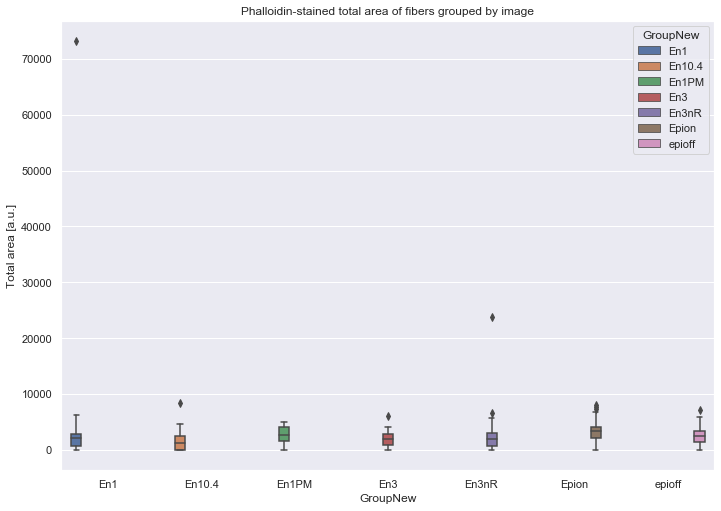

In [35]:
f = sns.boxplot(
    y=lab_area, 
    x=lab_experiment_group, 
    data=actin.groupby( [ lab_experiment_group, lab_image_number] ).sum().reset_index(), 
    hue=lab_experiment_group
)
f.set(
    title="Phalloidin-stained total area of fibers grouped by image",
    ylabel="Total area [a.u.]")

f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

## Studying nuclei

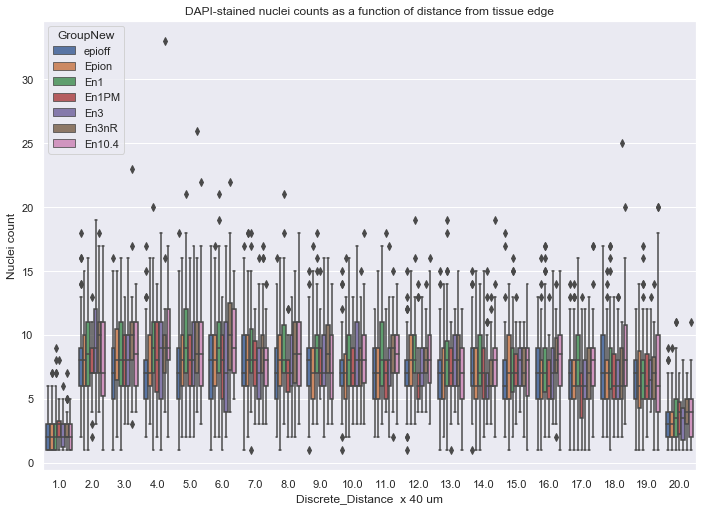

In [36]:
f = sns.boxplot(
    data = nuclei.groupby([lab_discrete_distance, lab_image_number, lab_experiment_group]).count().reset_index(),
    hue = lab_experiment_group,
    x = lab_discrete_distance, 
    y = lab_distance, #the value here does not matter since we plot *counts*
)
#f = sns.displot(
#    data = nuclei,
#    col = lab_experiment_group,
#    x = lab_discrete_distance,
#    kind = "hist",
#)
f.set(
    ylabel="Nuclei count",
    title="DAPI-stained nuclei counts as a function of distance from tissue edge"
)
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

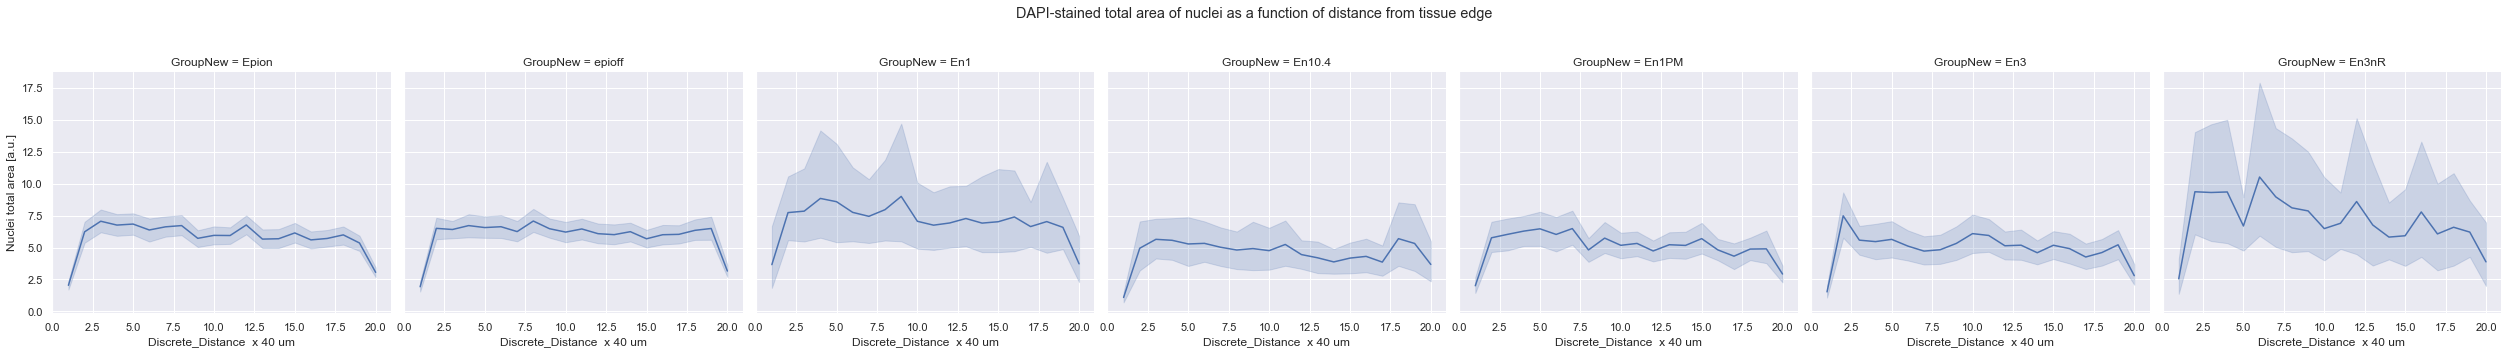

In [37]:
f = sns.relplot(
    y=lab_area, 
    x=lab_discrete_distance, 
    data=nuclei.groupby( [ lab_experiment_group, lab_discrete_distance, lab_image_number] ).sum(), 
    col=lab_experiment_group, 
    kind="line",
    col_order=group_order
)
f.set(
    ylabel="Nuclei total area [a.u.]",
    xlim=(x_lim, y_lim),
)
f.fig.suptitle( "DAPI-stained total area of nuclei as a function of distance from tissue edge" )
f.fig.subplots_adjust( top=.8 )
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

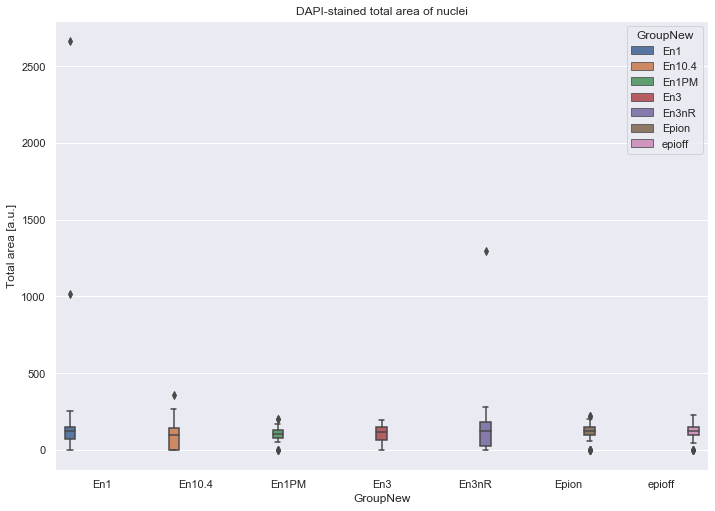

In [38]:
f = sns.boxplot(
    y=lab_area, 
    x=lab_experiment_group,
    data=nuclei.groupby( [ lab_experiment_group, lab_image_number] ).sum().reset_index(),
    hue=lab_experiment_group, 
)
f.set(
    title="DAPI-stained total area of nuclei",
    ylabel="Total area [a.u.]")
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

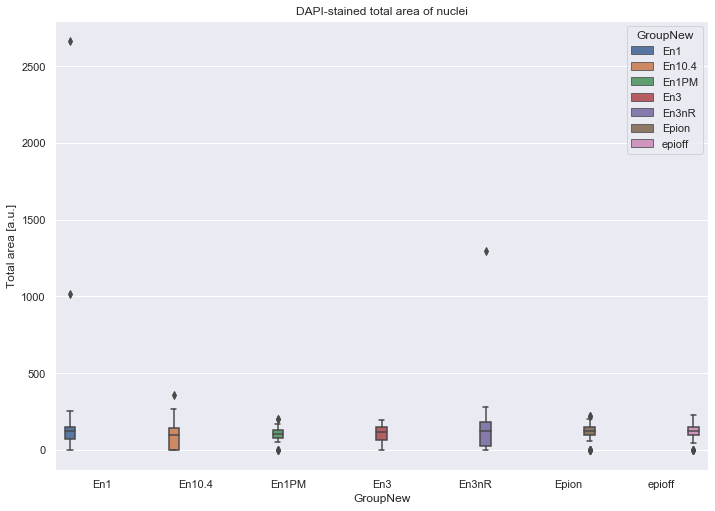

In [39]:

f = sns.boxplot(
    y=lab_area, 
    x=lab_experiment_group,
    data=nuclei.groupby( [ lab_experiment_group, lab_image_number] ).sum().reset_index(), 
    hue=lab_experiment_group, 
)
f.set(
    title="DAPI-stained total area of nuclei",
    ylabel="Total area [a.u.]")
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

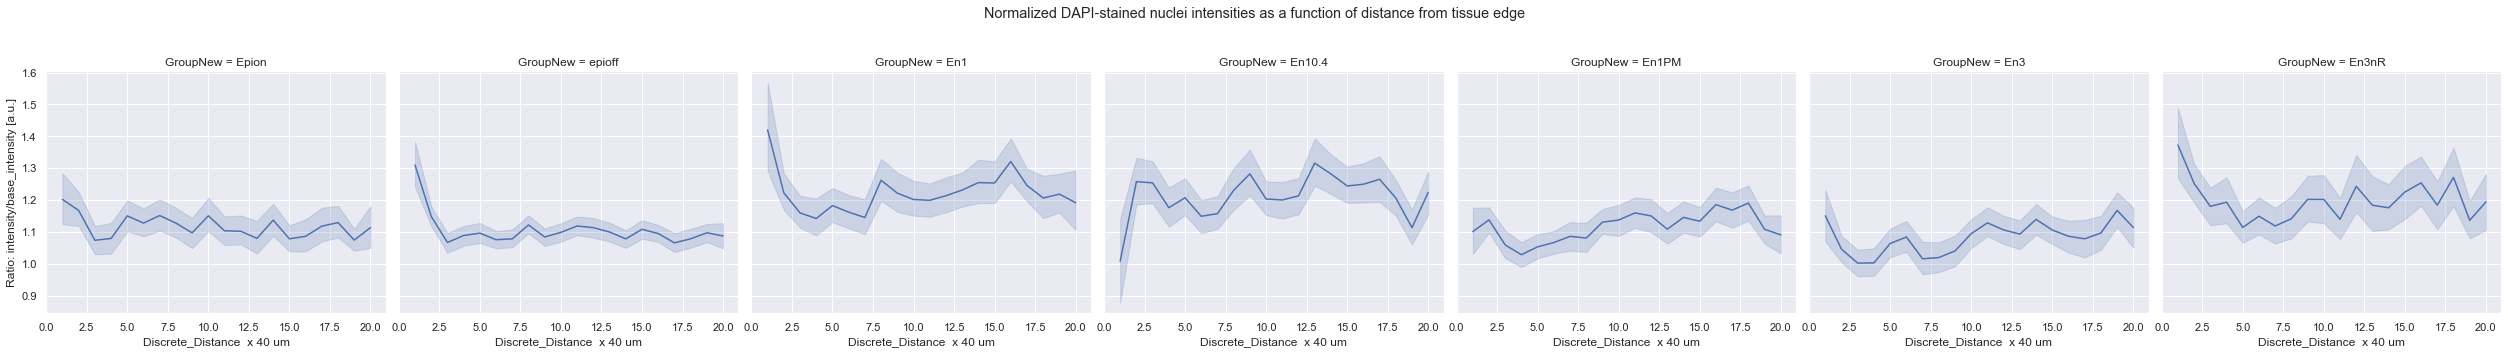

In [40]:
f = sns.relplot(
    y=lab_dapi_int, 
    x=lab_discrete_distance,
    #x=lab_discrete_distance, 
    data=nuclei,#.groupby( [ lab_experiment_group, lab_image_number] ), 
    col=lab_experiment_group, 
    kind="line",
    col_order=group_order
)
f.set(
    ylabel=(lambda x: "Ratio: intensity/base_intensity [a.u.]" if x else "Intensity [a.u.]")(normalized),
    xlim=(x_lim, y_lim),
)
f.fig.suptitle( l_normalized()+"DAPI-stained nuclei intensities as a function of distance from tissue edge" )
f.fig.subplots_adjust( top=.8 )
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

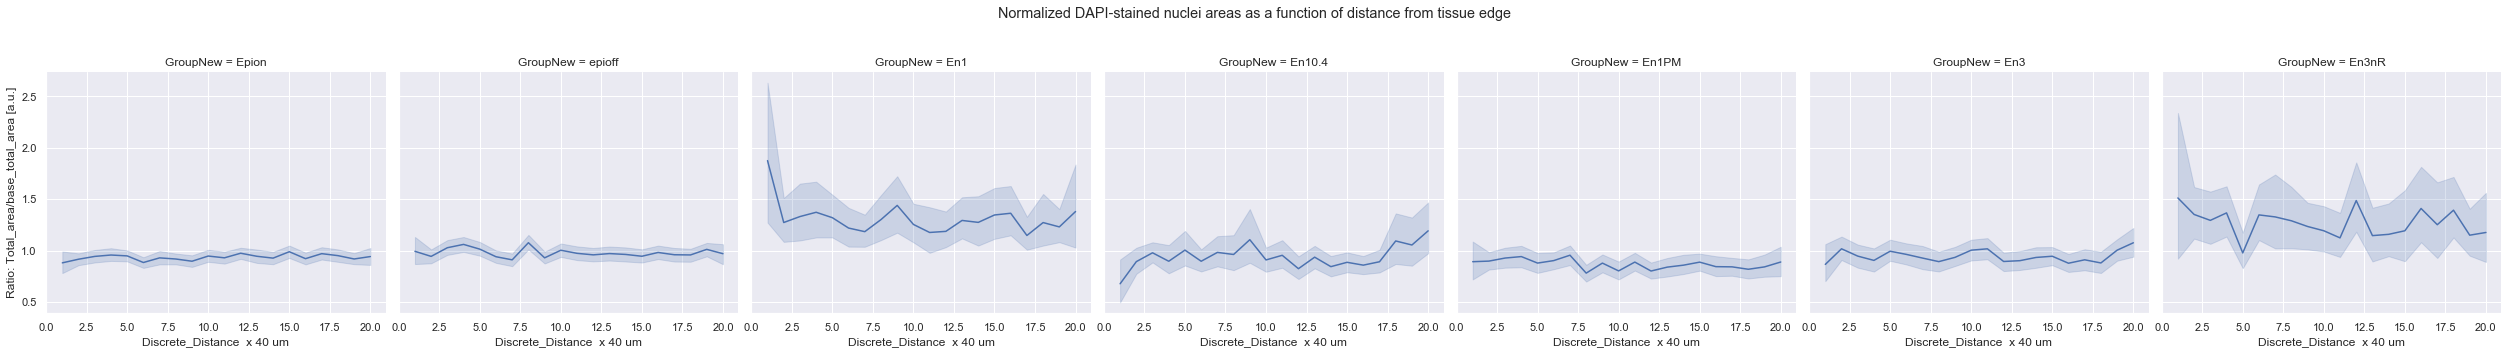

In [41]:
f = sns.relplot(
    y=lab_area, 
    x=lab_discrete_distance,
    #x=lab_discrete_distance, 
    data=nuclei,#.groupby( [ lab_experiment_group, lab_image_number] ), 
    col=lab_experiment_group, 
    kind="line",
    col_order=group_order
)
f.set(
    ylabel=(lambda x: "Ratio: Total_area/base_total_area [a.u.]" if x else "Total_area/base_total_area [a.u.]")(normalized),
    xlim=(x_lim, y_lim),
)
f.fig.suptitle( l_normalized()+"DAPI-stained nuclei areas as a function of distance from tissue edge" )
f.fig.subplots_adjust( top=.8 )
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

# Cell count based on DAPI

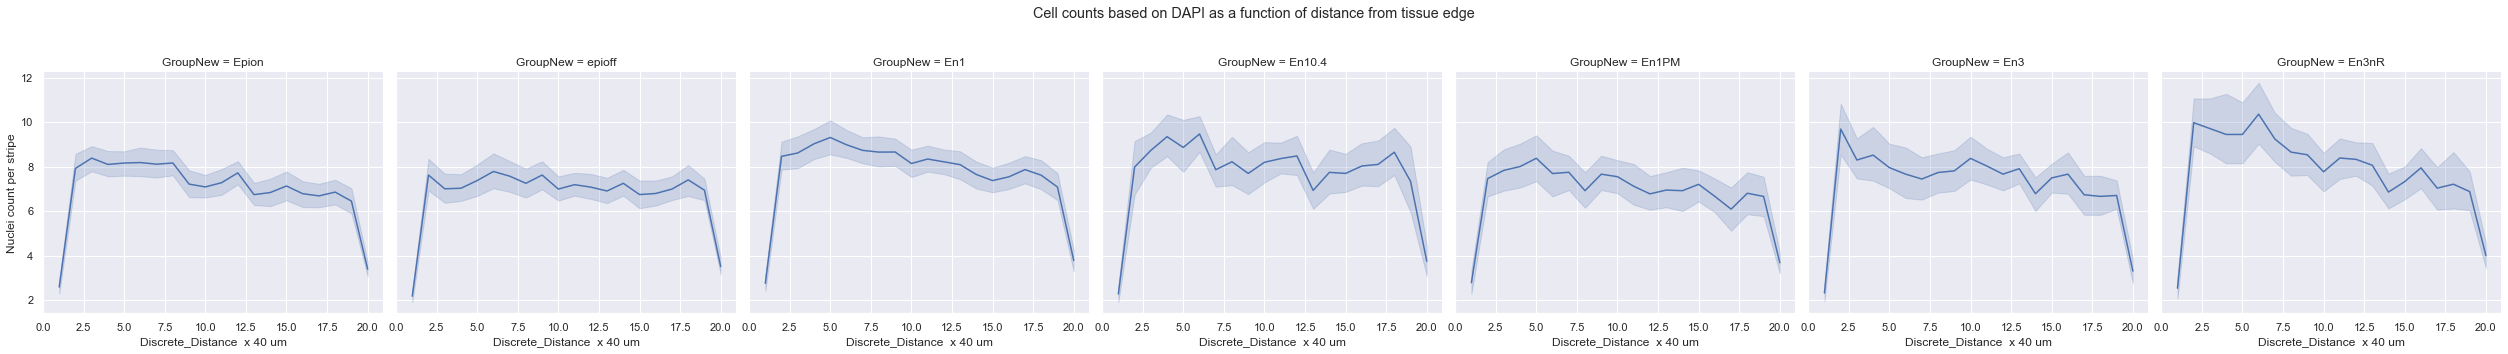

In [42]:
f = sns.relplot(
    y='ObjectNumber', 
    x=lab_discrete_distance,
    #x=lab_discrete_distance, 
    data=nuclei.groupby( [ lab_experiment_group, lab_image_number, lab_discrete_distance] ).count(), 
    col=lab_experiment_group, 
    kind="line",
    col_order=group_order
)
f.set(
    #title="Phaloidin in medium normalized intensity as a function of distance from tissue edge",
    ylabel="Nuclei count per stripe",
    xlim=(x_lim, y_lim),)
f.fig.suptitle( 'Cell counts based on DAPI as a function of distance from tissue edge' )
f.fig.subplots_adjust( top=.8 )
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

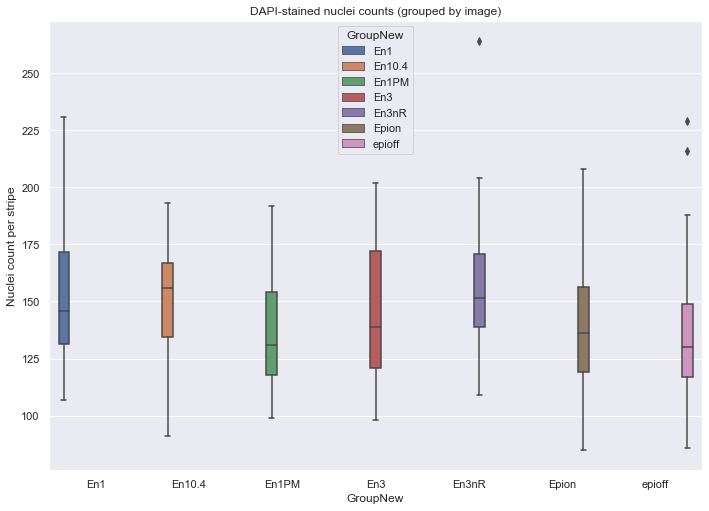

In [43]:
f = sns.boxplot(
    y='ObjectNumber', 
    x=lab_experiment_group,
    #x=lab_discrete_distance, 
    data=nuclei.groupby( [ lab_experiment_group, lab_image_number] ).count().reset_index(), 
    hue=lab_experiment_group, 
    #kind="scatter"
)
f.set(
    title="DAPI-stained nuclei counts (grouped by image)",
    ylabel="Nuclei count per stripe"
)
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)


# Fiber count based on Phalloidine

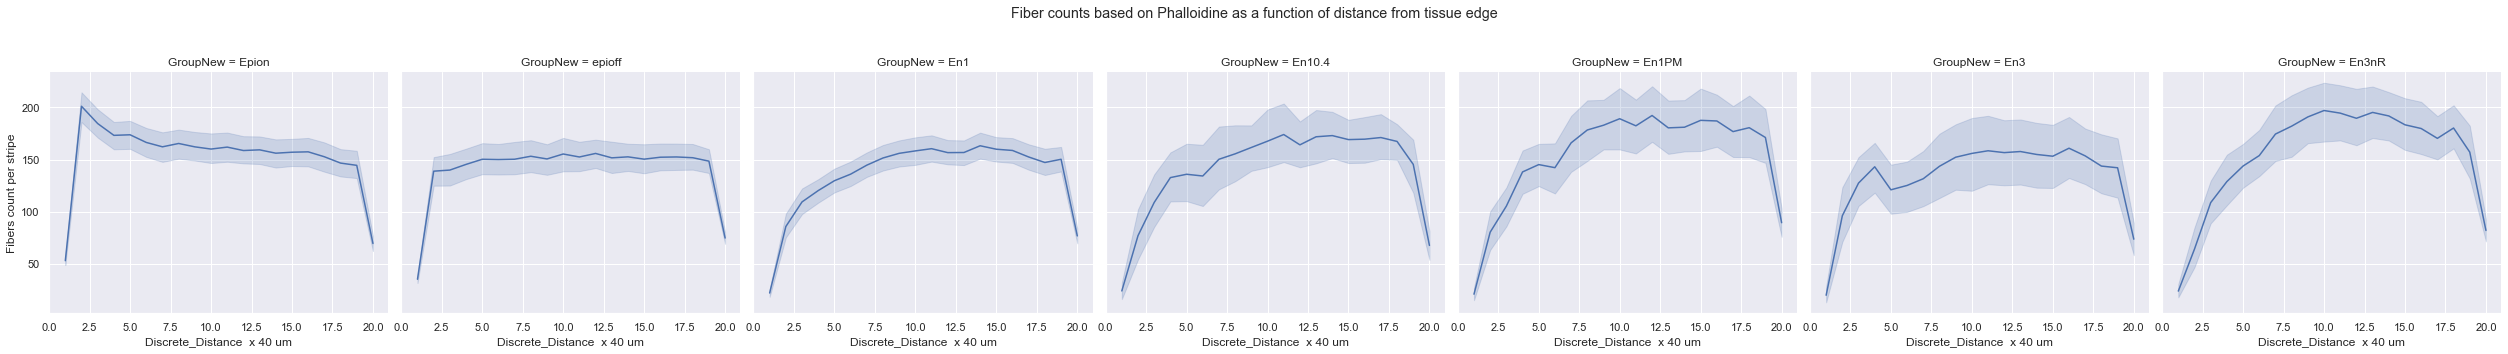

In [44]:
f = sns.relplot(
    y='ObjectNumber', 
    x=lab_discrete_distance,
    #x=lab_discrete_distance, 
    data=actin.groupby( [ lab_experiment_group, lab_image_number, lab_discrete_distance] ).count(), 
    col=lab_experiment_group, 
    kind="line",
    col_order=group_order
)
f.set(
    #title="Phaloidin in medium normalized intensity as a function of distance from tissue edge",
    ylabel="Fibers count per stripe",
    xlim=(x_lim, y_lim),
)
f.fig.suptitle( 'Fiber counts based on Phalloidine as a function of distance from tissue edge' )
f.fig.subplots_adjust( top=.8 )
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

# Checks

In [45]:
### Probe grid counts wrt edge distance

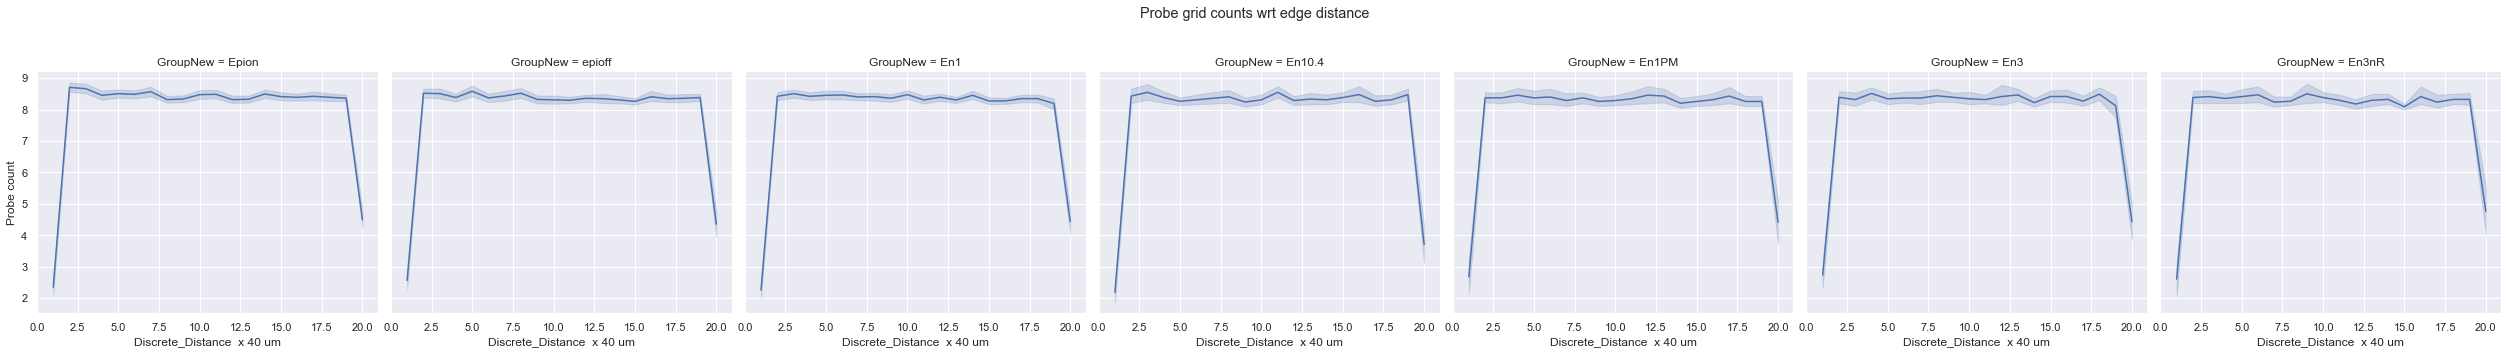

In [46]:
f = sns.relplot(
    y='ObjectNumber', 
    x=lab_discrete_distance,
    #x=lab_discrete_distance, 
    data=probes.groupby( [ lab_experiment_group, lab_image_number, lab_discrete_distance] ).count(), 
    col=lab_experiment_group, 
    kind="line",
    alpha=1,
    col_order=group_order
)
f.set(
    ylabel="Probe count",
    xlim=(x_lim, y_lim),
)
f.fig.suptitle( 'Probe grid counts wrt edge distance' )
f.fig.subplots_adjust( top=.8 )
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

### Probe grid spacing wrt edge distance

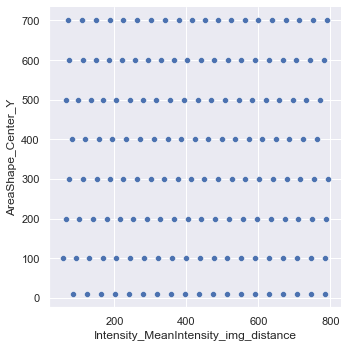

In [47]:
f =  sns.relplot(
        x = lab_distance,
        y = "AreaShape_Center_Y",
        data=probes[ probes[ lab_image_number ] == 1 ]  
)
f.title="Distribution of probes with edge to boundary distance",
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

### Probe grid spacing in absolute distance

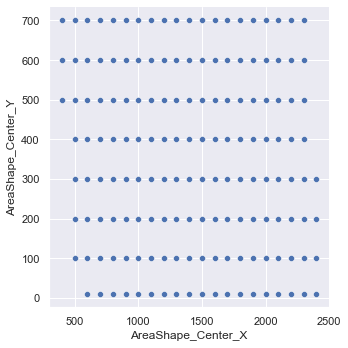

In [48]:
f = sns.relplot(
        x = "AreaShape_Center_X",
        y = "AreaShape_Center_Y",
        data=probes[ probes[ lab_image_number ] == 1 ]  
)
f.title="Distribution of probes with cartesian distance",
f.figure.savefig(pj(root, results_path, ('%03d-discrete_distance-'+str(discrete_distance_um)+'-derivative_thr-'+str(derivative_thr)+'.png') % num()), dpi=300)

In [49]:
probes.groupby( [lab_experiment_group, lab_image_number] ).agg(['unique'])

ObjectNumber  \
                                                                 unique   
GroupNew ImageNumber                                                      
En1      9            [7, 8, 9, 10, 15, 16, 17, 18, 19, 20, 21, 24, ...   
         10           [12, 13, 14, 15, 16, 17, 18, 19, 23, 24, 25, 2...   
         11           [7, 8, 9, 10, 18, 19, 20, 21, 22, 23, 24, 25, ...   
         69           [6, 7, 20, 21, 22, 23, 24, 25, 26, 27, 40, 41,...   
         70           [13, 14, 15, 16, 17, 18, 19, 33, 34, 35, 36, 3...   
...                                                                 ...   
epioff   392          [22, 23, 24, 25, 28, 39, 40, 41, 42, 43, 44, 4...   
         393          [17, 18, 19, 20, 21, 22, 23, 24, 34, 35, 36, 3...   
         415          [45, 46, 47, 48, 49, 50, 51, 52, 65, 66, 67, 6...   
         416          [29, 30, 31, 32, 45, 46, 47, 48, 49, 50, 51, 5...   
         417          [5, 6, 7, 25, 26, 27, 28, 29, 31, 32, 45, 46, ...   

                                                AreaShape_Area  \
                                                        unique   
GroupNew ImageNumber                                             
En1      9            [0.7026534701560507, 1.3712429412836238]   
         10           [0.6657174497706059, 1.2991615250751463]   
         11            [0.5577449854201644, 1.088451002915967]   
         69           [1.0512571048184751, 0.5386860566337242]   
         70             [0.5373744253362847, 1.04869742891197]   
...                                                        ...   
epioff   392          [1.0712235846595357, 0.5489172971562745]   
         393          [0.5351084769002808, 1.0442753831523541]   
         415          [0.5528549281341146, 1.0789079538586857]   
         416          [1.0712235846595357, 0.5489172971562745]   
         417           [0.545678532062504, 1.0649030668482138]   

                     AreaShape_BoundingBoxArea  \
                                        unique   
GroupNew ImageNumber                             
En1      9                        [1326, 2601]   
         10                       [1326, 2601]   
         11                       [1326, 2601]   
         69                       [2601, 1326]   
         70                       [1326, 2601]   
...                                        ...   
epioff   392                      [2601, 1326]   
         393                      [1326, 2601]   
         415                      [1326, 2601]   
         416                      [2601, 1326]   
         417                      [1326, 2601]   

                                         AreaShape_BoundingBoxMaximum_X  \
                                                                 unique   
GroupNew ImageNumber                                                      
En1      9            [326, 426, 526, 626, 726, 826, 926, 1026, 1126...   
         10           [526, 626, 726, 826, 926, 1026, 1126, 1226, 13...   
         11           [426, 526, 626, 726, 826, 926, 1026, 1126, 122...   
         69           [326, 426, 526, 626, 726, 826, 926, 1026, 1126...   
         70           [426, 526, 626, 726, 826, 926, 1026, 1126, 122...   
...                                                                 ...   
epioff   392          [426, 526, 626, 726, 826, 926, 1026, 1126, 122...   
         393          [326, 426, 526, 626, 726, 826, 926, 1026, 1126...   
         415          [726, 826, 926, 1026, 1126, 1226, 1326, 1426, ...   
         416          [426, 526, 626, 726, 826, 926, 1026, 1126, 122...   
         417          [326, 426, 526, 626, 726, 826, 926, 1026, 1126...   

                               AreaShape_BoundingBoxMaximum_Y  \
                                                       unique   
GroupNew ImageNumber                                            
En1      9            [26, 126, 226, 326, 426, 526, 626, 726]   
         10           [26, 126, 226, 326, 426, 526, 626, 726]   
      

In [50]:
# number of images per condition
probes.groupby( [lab_experiment_group, lab_image_number] ).agg(['unique'])
en = [i[0] for i in probes.groupby( [lab_experiment_group, lab_image_number] ).groups.keys()]
from collections import Counter
Counter(en)

Counter({'En1': 95,
         'En10.4': 42,
         'En1PM': 35,
         'En3': 41,
         'En3nR': 34,
         'Epion': 95,
         'epioff': 81})

In [51]:
r1 = [10, 100]
r2 = r1 * 4
r3 = r1 * 1000

